# Racism and hate spee

In [13]:
import pandas as pd

from keras.preprocessing.text import Tokenizer
from keras import preprocessing

from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics

from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.layers import Embedding
from keras.callbacks import EarlyStopping
from keras.layers import LSTM, Bidirectional
from keras import regularizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from wordcloud import WordCloud

from sentence_transformers import SentenceTransformer, util
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import umap.umap_ as umap

In [14]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model

In [15]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

### The function below combines several text preprocessing methods - each step is described in the comment

In [16]:
def pre_process_DF_document_corpus(corpus):
    
    
    lemmatizer = WordNetLemmatizer()
    
    corpus= corpus.apply(lambda x: x.lower().split()) # Tokenize
    corpus= [[word for word in article if len(word)>1] for article in corpus] #Remove 1 charchter words
    corpus= [[word for word in article if not word.isnumeric()] for article in corpus] #Remove digits but not words with numbers
    corpus= [[lemmatizer.lemmatize(word) for word in article] for article in corpus] # lemmatize words
    corpus= [[word for word in article if word not in stopwords.words('English')] for article in corpus] # Remove stop words
    corpus= [[word for word in tweet if not '@' in word] for tweet in corpus]
    corpus= [' '.join(x) for x in corpus]
    #corpus= ' '.join(str(corpus))
    return corpus

### We load the tweets (Provided by Analytics Vidhya) and verify their structure 

In [17]:
DF=pd.read_csv('train.csv', usecols=['label', 'tweet'])

In [18]:
DF.tweet.head(10).values

array([' @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run',
       "@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked",
       '  bihday your majesty',
       '#model   i love u take with u all the time in urð\x9f\x93±!!! ð\x9f\x98\x99ð\x9f\x98\x8eð\x9f\x91\x84ð\x9f\x91\x85ð\x9f\x92¦ð\x9f\x92¦ð\x9f\x92¦  ',
       ' factsguide: society now    #motivation',
       '[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo  ',
       ' @user camping tomorrow @user @user @user @user @user @user @user dannyâ\x80¦',
       "the next school year is the year for exams.ð\x9f\x98¯ can't think about that ð\x9f\x98\xad #school #exams   #hate #imagine #actorslife #revolutionschool #girl",
       'we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers  â\x80¦ ',
       " @user @user welcome h

### Tweets are passed thru the above-mentioned pre-processing function

In [19]:
DF.tweet=pre_process_DF_document_corpus(DF.tweet) 

### Here we perform a standard 70/30 train-test split

In [20]:
#df_train=DF[:round(0.7*len(DF))]
df_train=DF[:round(0.7*len(DF))]
df_test=DF[round(0.7*len(DF)):]

In [21]:
# Indices are reset to avoid issues during look-ups
df_test.reset_index(inplace=True, drop=True)

### The section below will implement BERT and TFIDF embeddings for the tweets

In [22]:
model_nli_means_tokens= SentenceTransformer('distilbert-base-nli-mean-tokens') # Moint the pre-trained distilled BERT model from HuggingFace library

In [23]:
X=model_nli_means_tokens.encode(df_train.tweet) # The tweets are encoded with the pre-trained model

### The same is done for TF-IDF embeddings, this time we're using SKlearn's implementation

In [24]:
tfidf_vect= TfidfVectorizer()

In [25]:
tfidf_train_sparse=tfidf_vect.fit_transform(df_train.tweet)

In [26]:
tfidf_train_dense=tfidf_train_sparse.todense() # Sparse vectors are converted to dense so they can be concatinated together with BERT vectors

In [27]:
tfidf_test_dense=tfidf_vect.transform(df_test.tweet).todense() # The same process is repeated for the test set

### The truth labels are stored in the y variable which will be used for training and testing

In [28]:
y= df_train.label

In [29]:
X_test=model_nli_means_tokens.encode(df_test.tweet) # Similar encoding of the test tweets with BERT

In [30]:
y_test=df_test.label

### Building a Deep Neural Network for text classification. The first model is trained using the combined BERT and TFIDF embeddings - c.f. the training part comments.
### In this model we use several regularization parameters such L2 regularization, dropout, and early stopping.

### You will note a 95% validation accuracy but be careful as this figure is deceiving since this is a very unbalanced dataset. F1-Score is explained later in this notebook, a measure which will reflect a better meteric of the model's performance

In [20]:
callback= EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True) # A very useful function that will pick the best validation accuracy epoch and stop the training when that metric is not improving anymore
model = models.Sequential()

# two intermediate layers with 16 hiddent units each with relu activation functions (which zero out negative values)
model.add(layers.Dense(128, activation='relu', input_shape=(np.hstack((tfidf_train_dense, X)).shape[1],)))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(128, activation='relu',  kernel_regularizer=regularizers.l2(l=0.01)))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l=0.01) ))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

# summarize model
print(model.summary())
# Note how we concatinate BERT and TFIDF embeddings using the np.hstack method below
history=model.fit(np.hstack((tfidf_train_dense, X)), y, epochs=50, batch_size = 512, validation_data=(np.hstack((tfidf_test_dense, X_test)),y_test), callbacks=[callback])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               4214272   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1

### Here is a neat way to visualize the architecture of your Deep Neural Network

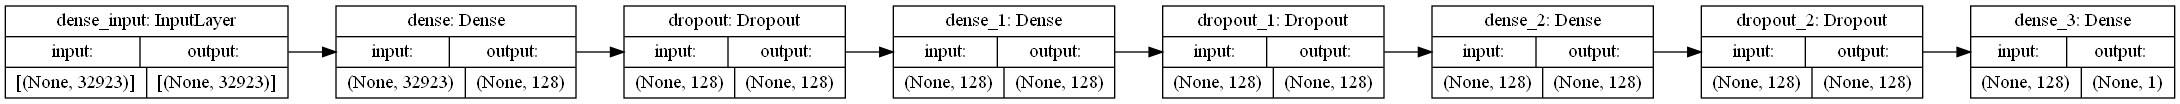

In [21]:
plot_model(model, to_file='model1.png', show_shapes=True, rankdir='LR')

### Below are important plots that inform you about the learning process of your model. They illustrate accuracy and loss over the training and validation sets

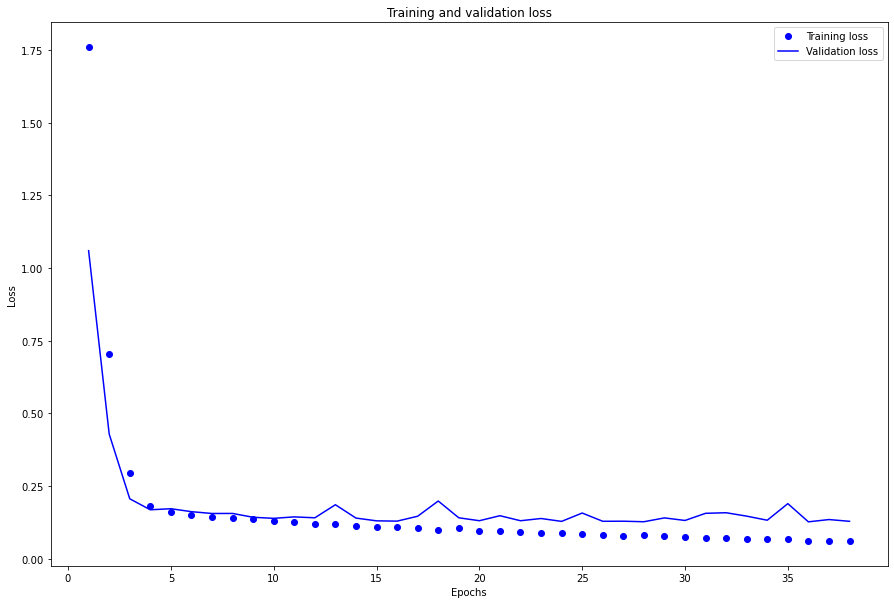

In [22]:
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)
plt.figure(figsize=(15,10))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

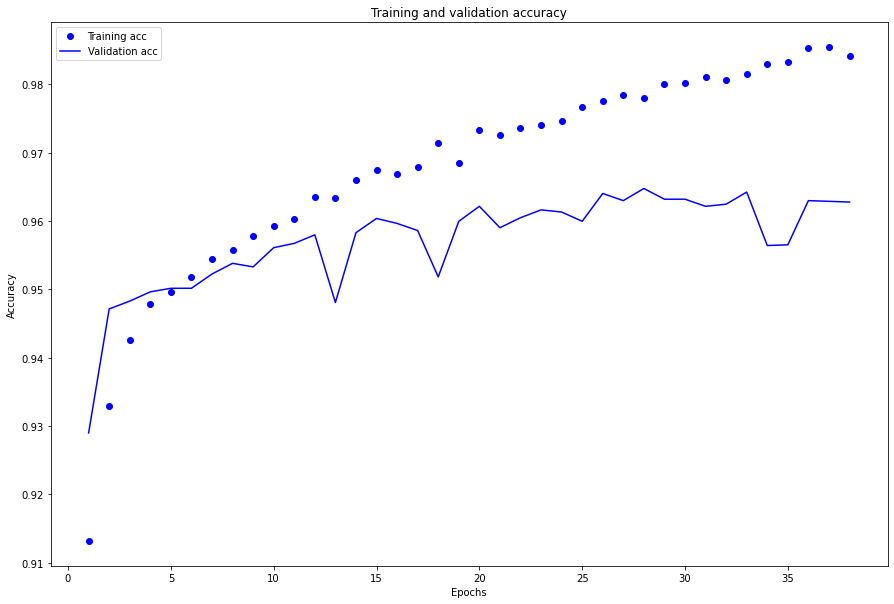

In [23]:
history_dict = history.history

acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

epochs = range(1, len(acc_values) + 1)
plt.figure(figsize=(15,10))

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [31]:
umap_embedded_train = umap.UMAP(n_neighbors=15, 
                            n_components=2, 
                            metric='cosine').fit_transform(np.hstack((tfidf_train_dense, X)))

### Below is a method to visualize how BERT-TFIDF embedding is managing to separate the tweets. This was done by reducing the embeddings to 2D using UMAP. Note that this is not an accurate way of proving separation boundaries but it still helps to get a rough estimate of the separation.

<AxesSubplot:>

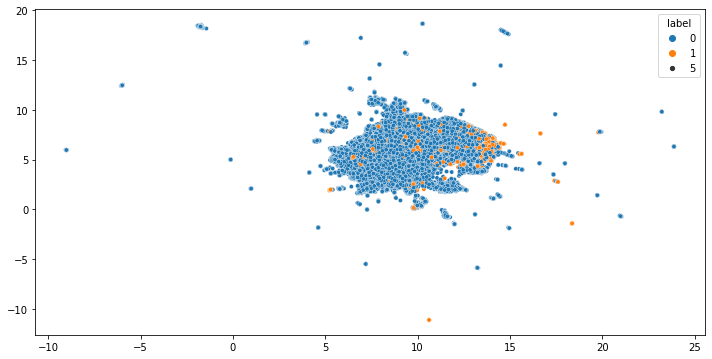

In [35]:
plt.figure(figsize=(12,6))
sns.scatterplot(x=umap_embedded_train[:,0], y=umap_embedded_train[:,1], hue=y, size=5)

### Below we build a function the retrieves the F1-score which is more important for this unbalanced Dataset since most of the training set (93%) contains non-hate speech tweets hence the accuracy score will give the wrong impression about the model's performance

In [25]:
def get_f1_score(model, test_data, true_labels, threshold=0.5):
    
    pred= model.predict(test_data)
    y_hat= np.zeros_like(pred)
    y_hat_idx= np.where(pred>threshold)[0]
    
    for i in range(len(pred)):
        if i in y_hat_idx:
            y_hat[i]=1
    
    return f1_score(true_labels, y_hat)

### Here is an out-of-the-box way to further fine-tune our model by performing a sort of a grid-search to identifiy the best threshold for the Sigmoid function (output layer) which would make the classification decision. The default threshold is normally 0.50 but the plots below will demonstrate that this can be fine-tuned to improve results by up to 3% in our case

In [26]:
f1=[]
for i in range(90):
    f1.append(get_f1_score(model, np.hstack((tfidf_test_dense, X_test)), y_test, i/100)) # F1-score is obtained using SKlearn's package
f1=np.array(f1)

optimal_threshold=np.where(f1==max(f1))[0][0]/100
optimal_threshold

0.47

In [28]:
np.where(max(f1)) # Our test shows that 0.40 is the best cut-off for the  classification decision decision

(array([0], dtype=int64),)

In [36]:
f1[47] # At this threshold, we get about 73.47% F1-Score

0.7235099337748345

In [30]:
f1[50] # If we stick to the standard 0.50 threshold, we'll get an F1-Score of 72.75%

0.7150084317032039

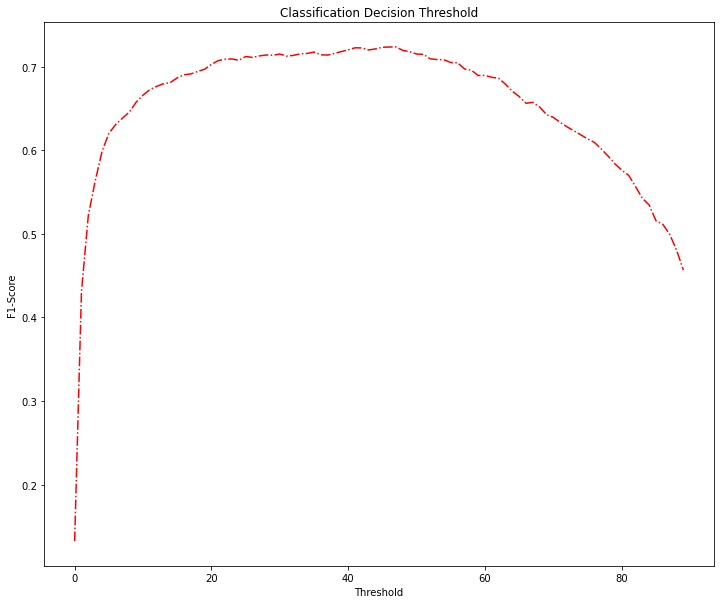

In [31]:
plt.figure(figsize=(12,10))
plt.plot(f1, 'r-.')
plt.title('Classification Decision Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1-Score')
plt.show()

### Below we run a few tests on conventional machine learning models such as Logistic Regression and Random forests and compare the results with the Deep Neural Network

In [32]:
LR=LogisticRegression()

In [33]:
LR.fit(tfidf_train_dense, y)
LR_y_hat=LR.predict(tfidf_test_dense)
f1_score(y_test, LR_y_hat)

0.42403628117913833

In [ ]:
LR.fit(np.hstack((tfidf_train_dense, X)), y)
LR_y_hat=LR.predict(np.hstack((tfidf_test_dense, X_test)))
f1_score(y_test, LR_y_hat)

### Beweare that Random Forrest models will take a very long time to run due to the lack of paralellization in their underlying Decision Tree Classifiers

In [ ]:
RF_classifier= RandomForestClassifier()
RF_classifier.fit(tfidf_train_dense,y)
RF_y_hat=RF_classifier.predict(tfidf_test_dense)
f1_score(y_test, RF_y_hat)

In [ ]:
RF_classifier= RandomForestClassifier()
RF_classifier.fit(np.hstack((tfidf_train_dense, X)),y)
RF_y_hat=RF_classifier.predict(np.hstack((tfidf_test_dense, X_test)))
f1_score(y_test, RF_y_hat)

### We note from the results above that Logistic Regression and Random Forest Performed Worse compared to our Deep Neural Network model. For more details about the architecture please check the project documentation in the repository. Also, if you have a related question, don't hesitate to communicate with me.

### It is equally important to note that Random Forest performed better with TFIDF embedding while Logistic Regression did a better job with the combined BERT-TFIDF embedding.

### See the below results obtained from various combinations of embeddings and ML models:

#### LR: Logistic Regression | RF: Random Forest | DNN: Deep Neural Network 

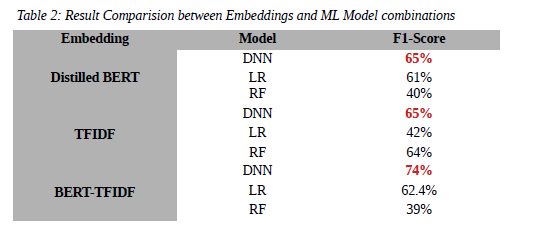